In [2]:
from __future__ import print_function, division

import ipywidgets as ipw

import numpy as np

from skimage.measure import block_reduce

from astropy.visualization import scale_image
from astropy.nddata import block_replicate
from ccdproc import CCDData

from photutils.morphology import (centroid_com, centroid_1dg,
                                  centroid_2dg)

import matplotlib.pyplot as plt

# The nbagg backend is what allows the interactivity.
%matplotlib nbagg

In [3]:
# This function really should be somewhere else eventually.
def scale_and_downsample(data, downsample=4,
                         min_percent=20,
                         max_percent=99.5):

    scaled_data = scale_image(data,
                              min_percent=min_percent,
                              max_percent=max_percent)

    if downsample > 1:
        scaled_data = block_reduce(scaled_data,
                                   block_size=(downsample, downsample))
    return scaled_data



In [9]:
# test_image contains the actual data
test_image = CCDData.read('M52-002R.fit')

# test_scaled is what is displayed later. It has been scaled to bring out the dim stars.
test_scaled = scale_and_downsample(test_image, downsample=1)

# For testing, just working with a part of the image.

x_cut = slice(0, 1000)
y_cut = slice(0, 1500)

# Slice out the piece we are using for testing from the display image.
test_scaled = test_scaled[x_cut, y_cut]

# Make sure we do the same cut from the data.
image_cut = test_image.data[x_cut, y_cut]

# For photometry or center finding need to do at least a rough removal of
# the background in the image.
image_cut -= np.median(image_cut)

# We could mask out bad pixels....for now we will not.
mask = image_cut > 1e6
mask.sum()

0

## None of the code below should end up in the notebook 

Eventually it should all be in python modules we are importing from or encapsulted in a class.

<IPython.core.display.Javascript object>


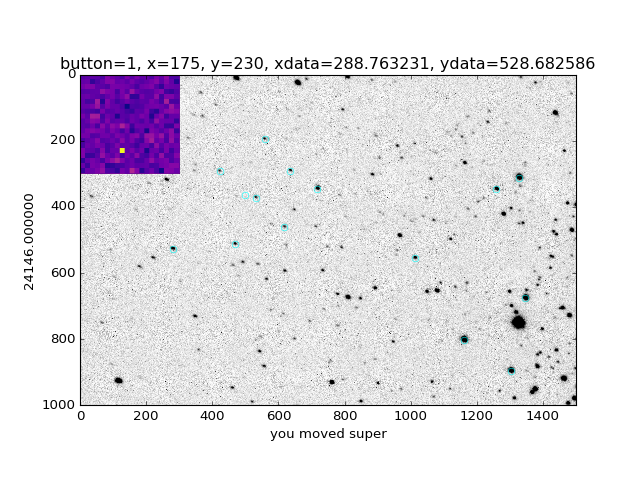

In [30]:
# Make the plot and display the scaled image. Stick with grayscale, but reversed.

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_scaled, cmap='gray_r',)

# Not quite sure why this is needed but it seems to be.
ax.set_xlim(0, test_scaled.shape[1])
ax.set_ylim(test_scaled.shape[0], 0)

# Define functions to handle some of the possible events. There is no reason we 
# need to actually handle all of these events, this is just to show the kind of 
# things that are possible.

def onclick(event):
    """
    Display a circle around the star closest to the place the user clicked.
    
    What 'closest' really means here is the location found in a small region
    near the click using a method pulled from photutils.
    """
    
    # Size of small region near the click.
    stamp_size = 20
    
    # Get the location of the click, rounded to the nearest pixel. Note
    # that the event.x is a number from 0 to 1 covering the whole drawing 
    # canvas, but event.xdata is the position indicated in the units 
    # on the axes.
    click_x_data = np.int(event.xdata)
    click_y_data = np.int(event.ydata)
    
    # Define a slice centered on the click
    slice_x = slice(click_x_data - stamp_size/2, click_x_data + stamp_size/2)
    slice_y = slice(click_y_data - stamp_size/2, click_y_data + stamp_size/2)

    # IMPORTANT: the cutout is done from the DATA not from the displayed image.
    cutout = image_cut[slice_y, slice_x]
    
    # Use centroid_2dg form photutils to find the center of any Gaussian-like maxima
    # in the cutout.
    center_x, center_y = centroid_2dg(cutout, mask=mask[slice_y, slice_x])

    # Really just changing the title for debugging to make sure something 
    # happened.
    ax.set_title('button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(
        event.button, event.x, event.y, event.xdata, event.ydata))
    
    # More debugging.
    ax.set_xlabel('x=%f y=%f, cx=%f cy=%f' % (center_x, center_y, 
                                           event.xdata + (center_x - stamp_size/2),
                                           event.ydata + (center_y - stamp_size/2)))
    
    # Add the marker in a few steps...
    
    # Calculate the x position of the centroid position in the larger
    # array (NOTE: this whole cutout thing could be improved by using
    # the Cutout2D class from astropy.nddata, I think)
    
    x_center_in_data = event.xdata + (center_x - stamp_size/2)
    y_center_in_data = event.ydata + (center_y - stamp_size/2)

    # Draw the marker. Eventually probably need to use ax.scatter to
    # be able to change the size of the marker in some sensible way.
    ax.plot([x_center_in_data], 
            [y_center_in_data], 'o', 
            markerfacecolor='none', 
            markeredgecolor='cyan',)
    
    display_cutout(cutout, ax)
    
    # Really no good reason for this.
    ax.set_ylabel('%f' % cutout.sum())

# You can call this (and the other event handling functions) anything
# you want.
def on_key(event):
    plt.xlabel('you pressed {}'.format(event.key, event.xdata, event.ydata))
    
def off_key(event):
    plt.xlabel('you released {}'.format(event.key, event.xdata, event.ydata))

# Drawing a new image for mouse movement events seems a little slow, at least
# if the plot is open for a while.
def mouse_moved(event):
    # Yuck. This code duplicates the click stuff above.
    stamp_size = 20
    click_x_data = np.int(event.xdata)
    click_y_data = np.int(event.ydata)
    slice_x = slice(click_x_data-stamp_size/2, click_x_data+stamp_size/2)
    slice_y = slice(click_y_data-stamp_size/2, click_y_data+stamp_size/2)
    cutout = image_cut[slice_y, slice_x]
    
    display_cutout(cutout, ax)
    plt.xlabel('you moved {}'.format(event.key, event.xdata, event.ydata))

def display_cutout(cutout, ax, min_width=300):
    # Display a little zoom-in of the cutout. No good reason 
    # for doing that, really. Use a different colormap so the cutout
    # stands out.
    
    # Scale up the cutout in size first so it isn't tiny...
    zoom_factor = min_width // max(cutout.shape)
    scaled_up = block_replicate(cutout, block_size=zoom_factor)
    # Display it.
    ax.imshow(scaled_up, cmap='plasma')
    

# This is where the functions defined above get connected to specific 
# events.
cid1 = fig.canvas.mpl_connect('button_press_event', onclick)
cid2 = fig.canvas.mpl_connect('key_press_event', on_key)
cid3 = fig.canvas.mpl_connect('key_release_event', off_key)
cid4 = fig.canvas.mpl_connect('motion_notify_event', mouse_moved)